In [2]:
import pandas as pd
import geopandas

## Import zipcodes shapefile

This will tell plotting software how to map our data.

In [3]:
zips_gdf = geopandas.read_file("cb_2019_us_zcta510_500k/cb_2019_us_zcta510_500k.shp", dtype={"ZCTA5CE10": object})

In [4]:
zips_gdf.head()

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,35586,8600000US35586,35586,472581657,892816,"MULTIPOLYGON (((-88.00160 33.81101, -88.00258 ..."
1,72454,8600000US72454,72454,263532032,775633,"POLYGON ((-90.41711 36.36553, -90.41686 36.390..."
2,71653,8600000US71653,71653,817752215,89308151,"POLYGON ((-91.45936 33.30273, -91.45758 33.381..."
3,19963,8600000US19963,19963,276290156,21123546,"POLYGON ((-75.50557 38.92751, -75.50313 38.927..."
4,81303,8600000US81303,81303,557450510,6445737,"POLYGON ((-108.04031 37.09764, -108.03896 37.1..."


Making sure the zipcodes are unique (if there are duplicates, `freq` below will be more than 1).

In [5]:
zips_gdf.ZCTA5CE10.describe()

count     33144
unique    33144
top       35586
freq          1
Name: ZCTA5CE10, dtype: object

## Importing ACS data

This has data about income, aggregated to the zipcode level by the Census Bureau.

In [8]:
acs2019 = pd.read_csv("data/ACS 2019_income_data_zip_accessible.csv", dtype={'ZIP': object}) #enforce same data type as shapefile

Making sure the row counts (`count`) haven't changed since we wrote the file.

In [9]:
acs2019.describe()

,total,me_total,vita_eligible,vita_per_capita
count,33120.000000,33120.000000,33120.000000,32519.000000
mean,3681.948762,172.515821,1780.967723,0.530213
std,5321.903126,143.212556,2692.419914,0.179676
min,0.000000,2.000000,0.000000,0.000000
25%,271.000000,60.000000,146.000000,0.415435
50%,1073.000000,125.000000,542.000000,0.538738
75%,5061.000000,257.000000,2283.250000,0.646342
max,41355.000000,1092.000000,25622.000000,1.000000


## Merging ACS and shape data

In [10]:
merged = pd.merge(zips_gdf, acs2019, left_on="ZCTA5CE10", right_on="ZIP", how="outer")

Some quick data quality checks:

* Are there any mismatches between the datasets?
* Why does the shapefile have ~500 more rows than ACS?

In [12]:
merged[((pd.isna(merged["ZIP"])) & ~(pd.isna(merged["ZCTA5CE10"])))][["ZCTA5CE10", "ZIP", "total"]].sort_values("ZCTA5CE10")

,ZCTA5CE10,ZIP,total
26375,00801,NaN,NaN
797,00802,NaN,NaN
8507,00820,NaN,NaN
10012,00823,NaN,NaN
4947,00824,NaN,NaN
1556,00830,NaN,NaN
8387,00831,NaN,NaN
29337,00840,NaN,NaN
29220,00841,NaN,NaN
2168,00850,NaN,NaN


In [13]:
merged[(~(pd.isna(merged["ZIP"])) & (pd.isna(merged["ZCTA5CE10"])))][["ZCTA5CE10", "ZIP", "total"]].sort_values("ZIP")

,ZCTA5CE10,ZIP,total


The ACS income data doesn't have estimates for every zip code the Census knew about, but it's missing less than 25 zip codes. More importantly, when we map this, we don't have any estimates without a corresponding shape. So all of the data we care about will end up on a map.

## Plotting

Some quick plots to make sure merging happened correctly.

In [14]:
import matplotlib

In [16]:
merged[["vita_eligible", "total"]].describe()

,vita_eligible,total
count,33120.000000,33120.000000
mean,1780.967723,3681.948762
std,2692.419914,5321.903126
min,0.000000,0.000000
25%,146.000000,271.000000
50%,542.000000,1073.000000
75%,2283.250000,5061.000000
max,25622.000000,41355.000000


In [18]:
merged["vita_per_capita"].describe()

count    32519.000000
mean         0.530213
std          0.179676
min          0.000000
25%          0.415435
50%          0.538738
75%          0.646342
max          1.000000
Name: vita_per_capita, dtype: float64

In [19]:
merged[((merged["total"] > 0) & (pd.isna(merged["vita_per_capita"])))]

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,ZIP,total,me_total,vita_eligible,vita_per_capita,id


In [21]:
merged["vita_per_capita"] = merged["vita_per_capita"].fillna(0)

In [27]:
merged.explore(column="vita_eligible")

<AxesSubplot:>

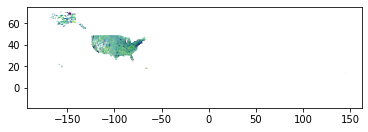

In [23]:
merged.explore(column="vita_per_capita")

In [ ]:
# ESRI shapefiles have col max size of 10 chars
# Renaming columns we care about
merged.rename(columns={
    'ZCTA5CE10': 'c_zipid',
    'AFFGEOID10': 'c_ageoid',
    'GEOID10': 'c_geoid',
    'ALAND10': 'c_land',
    'AWATER10': 'c_water',
    'Estimate - Total:': 'acs_total',
    'total_VITA_eligible': 'vita_total',
    'VITA_eligible_per_capita': 'vita_pc'
}, inplace=True)

In [ ]:
merged[["c_zipid", "c_ageoid", "c_geoid", "geometry", "acs_total", "vita_total", "vita_pc"]].to_file("ACS_VITA_eligible.shp")

In [ ]:
merged.columns